In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
train_dir = '/content/drive/MyDrive/brain_tumor_dataset/train-20250715T152614Z-1-001/train'
test_dir = '/content/drive/MyDrive/brain_tumor_dataset/test-20250715T152614Z-1-001/test'
valid_dir = '/content/drive/MyDrive/brain_tumor_dataset/valid-20250715T152941Z-1-001/valid'

In [3]:
import os

print(os.listdir(train_dir))

['_classes.csv', 'pituitary', 'glioma', 'meningioma', 'no_tumor']


**Understand the Dataset**
-Number of tumor types

In [4]:
import os
def count_images_and_class(folder):
  print(f"\nchecking folder:{folder}")
  count_class={}
  for class_name in os.listdir(folder):
    class_path=os.path.join(folder,class_name)
    if os.path.isdir(class_path):
      num_images=len(os.listdir(class_path))
      count_class[class_name]=num_images
  for cls,counts in count_class.items():
    print(f"{cls}:{counts} images")
  print(f"Total classes:{len(count_class)}")
count_images_and_class(train_dir)
count_images_and_class(test_dir)
count_images_and_class(valid_dir)




checking folder:/content/drive/MyDrive/brain_tumor_dataset/train-20250715T152614Z-1-001/train
pituitary:458 images
glioma:574 images
meningioma:358 images
no_tumor:335 images
Total classes:4

checking folder:/content/drive/MyDrive/brain_tumor_dataset/test-20250715T152614Z-1-001/test
glioma:80 images
pituitary:54 images
meningioma:63 images
no_tumor:49 images
Total classes:4

checking folder:/content/drive/MyDrive/brain_tumor_dataset/valid-20250715T152941Z-1-001/valid
meningioma:124 images
glioma:171 images
no_tumor:99 images
pituitary:128 images
Total classes:4


**Check for class imbalance**

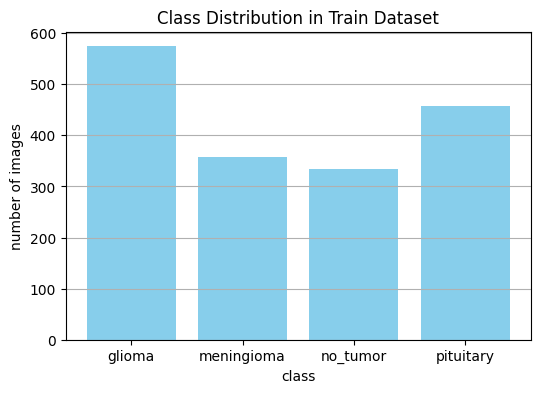

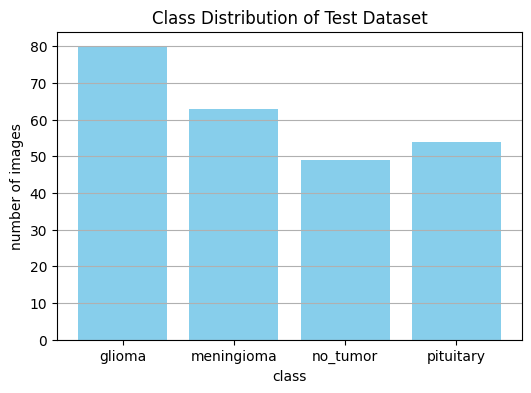

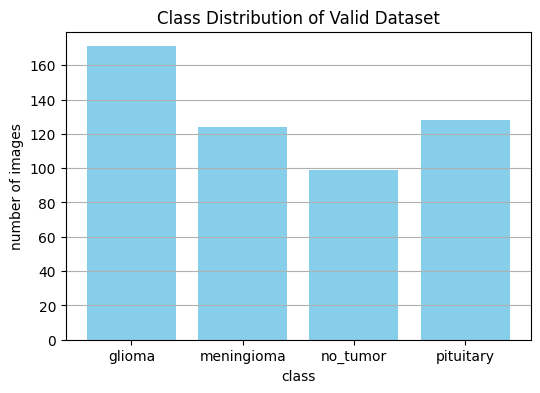

In [5]:
import matplotlib.pyplot as plt
def plot_class_distribution(folder,title):
  class_counts={}
  for class_name in sorted(os.listdir(folder)):
    class_path=os.path.join(folder,class_name)
    if os.path.isdir(class_path):
      class_counts[class_name]=len(os.listdir(class_path))

  plt.figure(figsize=(6,4))
  plt.bar(class_counts.keys(),class_counts.values(),color='skyblue')
  plt.title(title)
  plt.xlabel('class')
  plt.ylabel('number of images')
  plt.grid(axis='y')
  plt.show()

plot_class_distribution(train_dir,'Class Distribution in Train Dataset')
plot_class_distribution(test_dir,'Class Distribution of Test Dataset')
plot_class_distribution(valid_dir,'Class Distribution of Valid Dataset')

**Explore image distribution visually**

In [6]:
import random
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

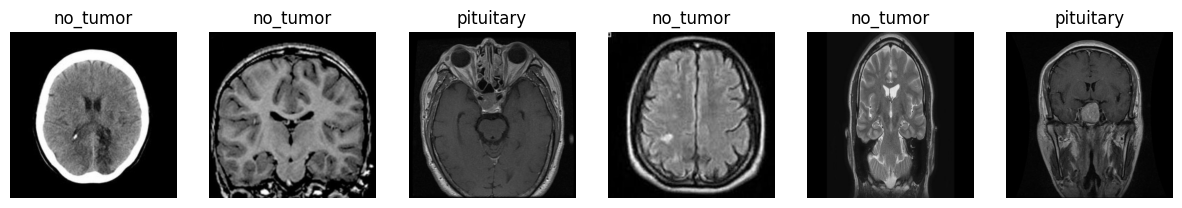

In [7]:
sample_dataset=ImageFolder(train_dir,transform=ToTensor())
def show_images(dataset,n=6):
  fig,axs=plt.subplots(1,n,figsize=(15,4))
  for i in range(n):
    img,label=dataset[random.randint(0,len(dataset)-1)]
    axs[i].imshow(img.permute(1,2,0))
    axs[i].axis('off')
    axs[i].set_title(dataset.classes[label])

  plt.show()
show_images(sample_dataset)

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen=ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'

)
test_datagen=ImageDataGenerator(rescale=(1./255))
valid_datagen=ImageDataGenerator(rescale=(1./255))

train_generator=train_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical'
)
valid_generator=valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)
test_generator=test_datagen.flow_from_directory(
    test_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 1725 images belonging to 4 classes.
Found 522 images belonging to 4 classes.
Found 246 images belonging to 4 classes.


**Build Model -CNN**

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout,BatchNormalization

In [10]:
model =Sequential()
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(224,224,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(4,activation='softmax'))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,170,372 (42.61 MB)

 Trainable params: 11,169,924 (42.61 MB)

 Non-trainable params: 448 (1.75 KB)

In [12]:
history=model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=valid_generator,
    validation_steps=len(valid_generator)
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 636s 12s/step - accuracy: 0.4190 - loss: 18.2619 - val_accuracy: 0.1897 - val_loss: 96.7615
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 79s 553ms/step - accuracy: 0.3727 - loss: 1.4315 - val_accuracy: 0.1897 - val_loss: 76.6774
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 30s 564ms/step - accuracy: 0.3637 - loss: 1.3575 - val_accuracy: 0.1897 - val_loss: 47.3495
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 562ms/step - accuracy: 0.4406 - loss: 1.3625 - val_accuracy: 0.1897 - val_loss: 28.2069
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 30s 560ms/step - accuracy: 0.4595 - loss: 1.1936 - val_accuracy: 0.1782 - val_loss: 31.0195
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 30s 565ms/step - accuracy: 0.3983 - loss: 1.2537 - val_accuracy: 0.2031 - val_loss: 22.5990
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 565ms/step - accuracy: 0.4290 - loss: 1.2503 - val_accuracy: 0.3180 - val_loss: 13.5135
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 31s 572ms/step - accuracy: 0.4661 - loss: 1.1842 - v

In [13]:
def history_plot(history):
  plt.figure(figsize=(12,4))
  plt.subplot(1,2,1)
  plt.plot(history.history['accuracy'],label='Train Accuracy')
  plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
  plt.title('Training vs Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(history.history['loss'],label='Training loss')
  plt.plot(history.history['val_loss'],label='Validation loss')
  plt.title('Training vs Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  plt.tight_layout()
  plt.show()

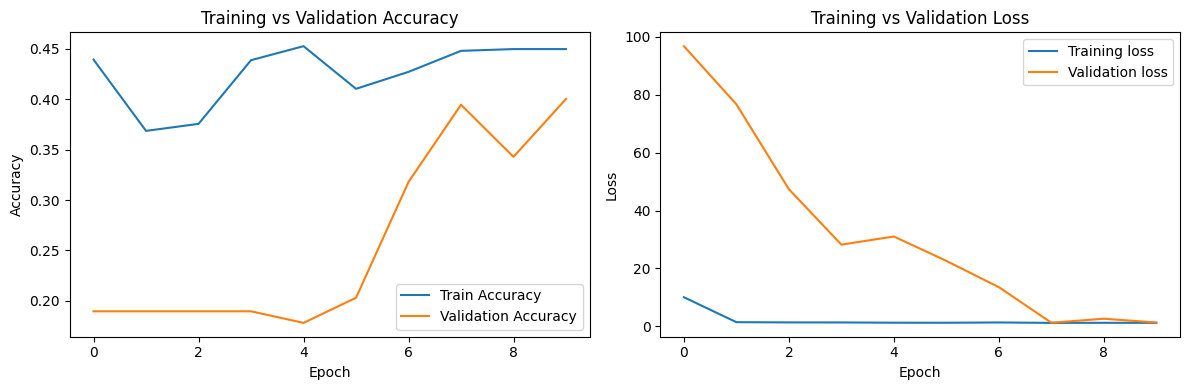

In [14]:
history_plot(history)

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Input,GlobalAveragePooling2D,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50,MobileNetV2,InceptionV3,EfficientNetB0

In [16]:
def build_model(base_model_class,input_shape=(224,224,3),num_classes=4):
  base_model=base_model_class(weights='imagenet',include_top=False,input_shape=input_shape)
  base_model.trainable=False

  inputs=Input(shape=input_shape)
  x=base_model(inputs,training=False)
  x=GlobalAveragePooling2D()(x)
  x=Dropout(0.5)(x)

  outputs=Dense(num_classes,activation='softmax')(x)

  model=Model(inputs,outputs)
  model.compile(optimizer=Adam(learning_rate=0.0001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  return model

In [17]:
resnet_model=build_model(ResNet50)
resnet_model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         8,196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,595,908 (90.01 MB)

 Trainable params: 8,196 (32.02 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [18]:
mobilenet_model=build_model(MobileNetV2)
mobilenet_model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,263,108 (8.63 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [19]:
inception_model=build_model(InceptionV3)
inception_model.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 5, 5, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │         8,196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,810,980 (83.20 MB)

 Trainable params: 8,196 (32.02 KB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [20]:
efficientnet_model=build_model(EfficientNetB0)
efficientnet_model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,054,695 (15.47 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

**FINE-TUNING**

In [21]:
from tensorflow.keras.optimizers import Adam

In [22]:
def fine_tuned_model(model,num_unfreeze_layers=30,learning_rate=1e-5):
  base_layer=model.layers[1]
  base_layer.trainable=True
  for layer in base_layer.layers[:-num_unfreeze_layers]:
    layer.trainable=False

  model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
  return model

In [23]:
resnet_finetune_model=fine_tuned_model(resnet_model,num_unfreeze_layers=50,learning_rate=1e-5)
resnet_finetune_model.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         8,196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,595,908 (90.01 MB)

 Trainable params: 16,958,724 (64.69 MB)

 Non-trainable params: 6,637,184 (25.32 MB)

In [24]:
mobilenet_finetune_model=fine_tuned_model(mobilenet_model,num_unfreeze_layers=50,learning_rate=1e-5)
mobilenet_finetune_model.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,263,108 (8.63 MB)

 Trainable params: 1,860,228 (7.10 MB)

 Non-trainable params: 402,880 (1.54 MB)

In [25]:
inception_finetune_model=fine_tuned_model(inception_model,num_unfreeze_layers=50,learning_rate=1e-5)
inception_finetune_model.summary()

Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 5, 5, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │         8,196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,810,980 (83.20 MB)

 Trainable params: 7,181,508 (27.40 MB)

 Non-trainable params: 14,629,472 (55.81 MB)

In [26]:
efficient_finetune_model=fine_tuned_model(efficientnet_model,num_unfreeze_layers=50,learning_rate=1e-5)
efficient_finetune_model.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,054,695 (15.47 MB)

 Trainable params: 2,531,988 (9.66 MB)

 Non-trainable params: 1,522,707 (5.81 MB)

**MODEL TRAINING**

In [27]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

In [28]:
early_stop=EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True)
model_checkpoint=ModelCheckpoint('best_model.h5',monitor='val_loss',save_best_only=True,mode='min',verbose=1)

In [29]:
cnn_history=model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    callbacks=[early_stop,model_checkpoint],
    steps_per_epoch=len(train_generator),
    validation_steps=len(valid_generator)

)

Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - accuracy: 0.4630 - loss: 1.2103
Epoch 1: val_loss improved from inf to 1.26981, saving model to best_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 32s 589ms/step - accuracy: 0.4631 - loss: 1.2104 - val_accuracy: 0.4828 - val_loss: 1.2698
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step - accuracy: 0.5172 - loss: 1.1842
Epoch 2: val_loss did not improve from 1.26981
54/54 ━━━━━━━━━━━━━━━━━━━━ 40s 564ms/step - accuracy: 0.5173 - loss: 1.1840 - val_accuracy: 0.4444 - val_loss: 2.1932
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - accuracy: 0.4832 - loss: 1.1804
Epoch 3: val_loss did not improve from 1.26981
54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 570ms/step - accuracy: 0.4833 - loss: 1.1803 - val_accuracy: 0.4349 - val_loss: 1.7377
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - accuracy: 0.4810 - loss: 1.1549
Epoch 4: val_loss improved from 1.26981 to 1.07786, saving model to best_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 32s 590ms/step - accuracy: 0.4810 - loss: 1.1551 - val_accuracy: 0.6054 - val_loss: 1.0779
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - accuracy: 0.4811 - loss: 1.1796
Epoch 5: val_loss improved from 1.07786 to 0.95286, saving model to best_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 31s 577ms/step - accuracy: 0.4810 - loss: 1.1793 - val_accuracy: 0.6322 - val_loss: 0.9529
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 518ms/step - accuracy: 0.5108 - loss: 1.1857
Epoch 6: val_loss did not improve from 0.95286
54/54 ━━━━━━━━━━━━━━━━━━━━ 31s 566ms/step - accuracy: 0.5103 - loss: 1.1864 - val_accuracy: 0.6015 - val_loss: 1.0219
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 516ms/step - accuracy: 0.4616 - loss: 1.1854
Epoch 7: val_loss did not improve from 0.95286
54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 568ms/step - accuracy: 0.4618 - loss: 1.1853 - val_accuracy: 0.5977 - val_loss: 0.9931
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - accuracy: 0.4668 - loss: 1.1620
Epoch 8: val_loss did not improve from 0.95286
54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 569ms/step - accuracy: 0.4667 - loss: 1.1623 - val_accuracy: 0.4885 - val_loss: 1.1622


In [30]:
resnet_history=resnet_model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    callbacks=[early_stop,model_checkpoint],
    steps_per_epoch=len(train_generator),
    validation_steps=len(valid_generator)
)

Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 764ms/step - accuracy: 0.4094 - loss: 1.2818
Epoch 1: val_loss did not improve from 0.95286
54/54 ━━━━━━━━━━━━━━━━━━━━ 80s 961ms/step - accuracy: 0.4106 - loss: 1.2801 - val_accuracy: 0.2452 - val_loss: 1.5978
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 537ms/step - accuracy: 0.5885 - loss: 1.0050
Epoch 2: val_loss did not improve from 0.95286
54/54 ━━━━━━━━━━━━━━━━━━━━ 32s 591ms/step - accuracy: 0.5885 - loss: 1.0054 - val_accuracy: 0.2739 - val_loss: 1.3599
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 533ms/step - accuracy: 0.5824 - loss: 1.0080
Epoch 3: val_loss did not improve from 0.95286
54/54 ━━━━━━━━━━━━━━━━━━━━ 34s 632ms/step - accuracy: 0.5829 - loss: 1.0073 - val_accuracy: 0.3831 - val_loss: 1.2787
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 533ms/step - accuracy: 0.6245 - loss: 0.9126
Epoch 4: val_loss did not improve from 0.95286
54/54 ━━━━━━━━━━━━━━━━━━━━ 32s 586ms/step - accuracy: 0.6248 - loss: 0.9121 - val_accuracy: 0.5881 - val_loss: 1.0

54/54 ━━━━━━━━━━━━━━━━━━━━ 42s 600ms/step - accuracy: 0.6545 - loss: 0.8780 - val_accuracy: 0.6801 - val_loss: 0.8710
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 534ms/step - accuracy: 0.6803 - loss: 0.8320
Epoch 6: val_loss improved from 0.87103 to 0.87077, saving model to best_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 33s 606ms/step - accuracy: 0.6801 - loss: 0.8321 - val_accuracy: 0.6360 - val_loss: 0.8708
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 532ms/step - accuracy: 0.6689 - loss: 0.8094
Epoch 7: val_loss improved from 0.87077 to 0.85164, saving model to best_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 33s 602ms/step - accuracy: 0.6687 - loss: 0.8099 - val_accuracy: 0.6686 - val_loss: 0.8516
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 547ms/step - accuracy: 0.6826 - loss: 0.8086
Epoch 8: val_loss improved from 0.85164 to 0.71361, saving model to best_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 33s 615ms/step - accuracy: 0.6826 - loss: 0.8084 - val_accuracy: 0.7337 - val_loss: 0.7136
Epoch 9/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - accuracy: 0.6833 - loss: 0.7939
Epoch 9: val_loss did not improve from 0.71361
54/54 ━━━━━━━━━━━━━━━━━━━━ 39s 582ms/step - accuracy: 0.6836 - loss: 0.7932 - val_accuracy: 0.7184 - val_loss: 0.7438
Epoch 10/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - accuracy: 0.6886 - loss: 0.7835
Epoch 10: val_loss did not improve from 0.71361
54/54 ━━━━━━━━━━━━━━━━━━━━ 40s 579ms/step - accuracy: 0.6886 - loss: 0.7833 - val_accuracy: 0.7184 - val_loss: 0.7456


In [31]:
mobilenet_history=mobilenet_model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    callbacks=[early_stop,model_checkpoint],
    steps_per_epoch=len(train_generator),
    validation_steps=len(valid_generator)
)

Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 685ms/step - accuracy: 0.2816 - loss: 1.7868
Epoch 1: val_loss did not improve from 0.71361
54/54 ━━━━━━━━━━━━━━━━━━━━ 68s 853ms/step - accuracy: 0.2824 - loss: 1.7839 - val_accuracy: 0.4483 - val_loss: 1.3847
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 502ms/step - accuracy: 0.5038 - loss: 1.1539
Epoch 2: val_loss did not improve from 0.71361
54/54 ━━━━━━━━━━━━━━━━━━━━ 55s 557ms/step - accuracy: 0.5046 - loss: 1.1526 - val_accuracy: 0.5211 - val_loss: 1.1922
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.6829 - loss: 0.8337
Epoch 3: val_loss did not improve from 0.71361
54/54 ━━━━━━━━━━━━━━━━━━━━ 30s 548ms/step - accuracy: 0.6831 - loss: 0.8331 - val_accuracy: 0.5307 - val_loss: 1.0928
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - accuracy: 0.7237 - loss: 0.7047
Epoch 4: val_loss did not improve from 0.71361
54/54 ━━━━━━━━━━━━━━━━━━━━ 30s 556ms/step - accuracy: 0.7240 - loss: 0.7042 - val_accuracy: 0.5402 - val_loss: 1.0

In [32]:
inception_history=inception_model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    callbacks=[early_stop,model_checkpoint],
    steps_per_epoch=len(train_generator),
    validation_steps=len(valid_generator)
)

Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 770ms/step - accuracy: 0.3202 - loss: 1.4380
Epoch 1: val_loss did not improve from 0.71361
54/54 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.3219 - loss: 1.4353 - val_accuracy: 0.5575 - val_loss: 0.9833
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - accuracy: 0.6270 - loss: 0.9360
Epoch 2: val_loss did not improve from 0.71361
54/54 ━━━━━━━━━━━━━━━━━━━━ 32s 589ms/step - accuracy: 0.6276 - loss: 0.9351 - val_accuracy: 0.6839 - val_loss: 0.7940
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - accuracy: 0.7164 - loss: 0.7435
Epoch 3: val_loss improved from 0.71361 to 0.63498, saving model to best_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 595ms/step - accuracy: 0.7166 - loss: 0.7429 - val_accuracy: 0.7701 - val_loss: 0.6350
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 516ms/step - accuracy: 0.7591 - loss: 0.6596
Epoch 4: val_loss improved from 0.63498 to 0.53475, saving model to best_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 43s 628ms/step - accuracy: 0.7592 - loss: 0.6590 - val_accuracy: 0.8027 - val_loss: 0.5348
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 517ms/step - accuracy: 0.7981 - loss: 0.5585
Epoch 5: val_loss improved from 0.53475 to 0.47059, saving model to best_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 32s 589ms/step - accuracy: 0.7983 - loss: 0.5581 - val_accuracy: 0.8314 - val_loss: 0.4706
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - accuracy: 0.8132 - loss: 0.5104
Epoch 6: val_loss improved from 0.47059 to 0.43062, saving model to best_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 32s 586ms/step - accuracy: 0.8133 - loss: 0.5103 - val_accuracy: 0.8391 - val_loss: 0.4306
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 518ms/step - accuracy: 0.8447 - loss: 0.4553
Epoch 7: val_loss improved from 0.43062 to 0.41221, saving model to best_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 584ms/step - accuracy: 0.8447 - loss: 0.4553 - val_accuracy: 0.8525 - val_loss: 0.4122
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 516ms/step - accuracy: 0.8222 - loss: 0.4475
Epoch 8: val_loss improved from 0.41221 to 0.38557, saving model to best_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 32s 585ms/step - accuracy: 0.8223 - loss: 0.4473 - val_accuracy: 0.8602 - val_loss: 0.3856
Epoch 9/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - accuracy: 0.8683 - loss: 0.3925
Epoch 9: val_loss improved from 0.38557 to 0.36178, saving model to best_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 32s 590ms/step - accuracy: 0.8682 - loss: 0.3924 - val_accuracy: 0.8640 - val_loss: 0.3618
Epoch 10/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 518ms/step - accuracy: 0.8726 - loss: 0.3601
Epoch 10: val_loss improved from 0.36178 to 0.34891, saving model to best_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 31s 583ms/step - accuracy: 0.8725 - loss: 0.3602 - val_accuracy: 0.8755 - val_loss: 0.3489


In [33]:
efficientnet_history=efficientnet_model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    callbacks=[early_stop,model_checkpoint],
    steps_per_epoch=len(train_generator),
    validation_steps=len(valid_generator)
)

Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 778ms/step - accuracy: 0.2607 - loss: 1.4248
Epoch 1: val_loss did not improve from 0.34891
54/54 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.2611 - loss: 1.4245 - val_accuracy: 0.2375 - val_loss: 1.5011
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.2890 - loss: 1.4043
Epoch 2: val_loss did not improve from 0.34891
54/54 ━━━━━━━━━━━━━━━━━━━━ 40s 554ms/step - accuracy: 0.2891 - loss: 1.4042 - val_accuracy: 0.2375 - val_loss: 1.4851
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 510ms/step - accuracy: 0.3048 - loss: 1.4034
Epoch 3: val_loss did not improve from 0.34891
54/54 ━━━━━━━━━━━━━━━━━━━━ 42s 564ms/step - accuracy: 0.3049 - loss: 1.4032 - val_accuracy: 0.2375 - val_loss: 1.4594
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - accuracy: 0.2862 - loss: 1.3999
Epoch 4: val_loss did not improve from 0.34891
54/54 ━━━━━━━━━━━━━━━━━━━━ 31s 564ms/step - accuracy: 0.2862 - loss: 1.4000 - val_accuracy: 0.2375 - val_loss: 1.4257

In [34]:
def history_plot(history, title='Model Performance'):
    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(title + ' - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(title + ' - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

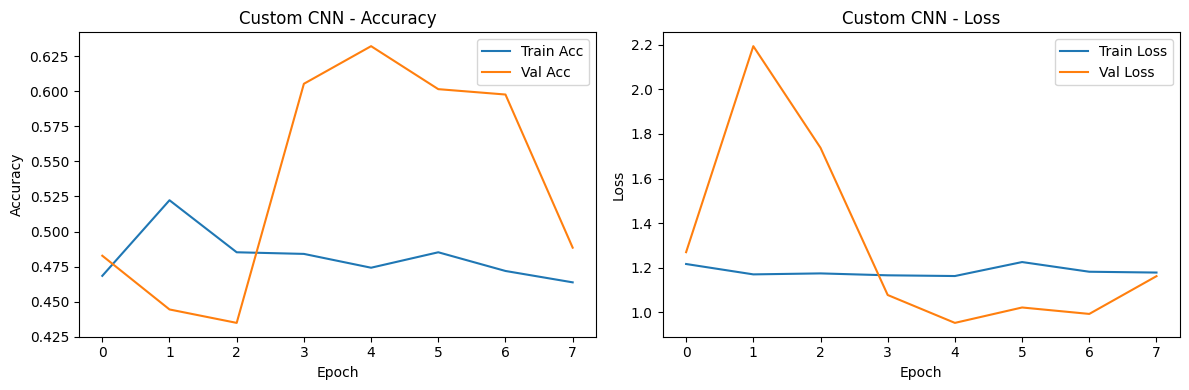

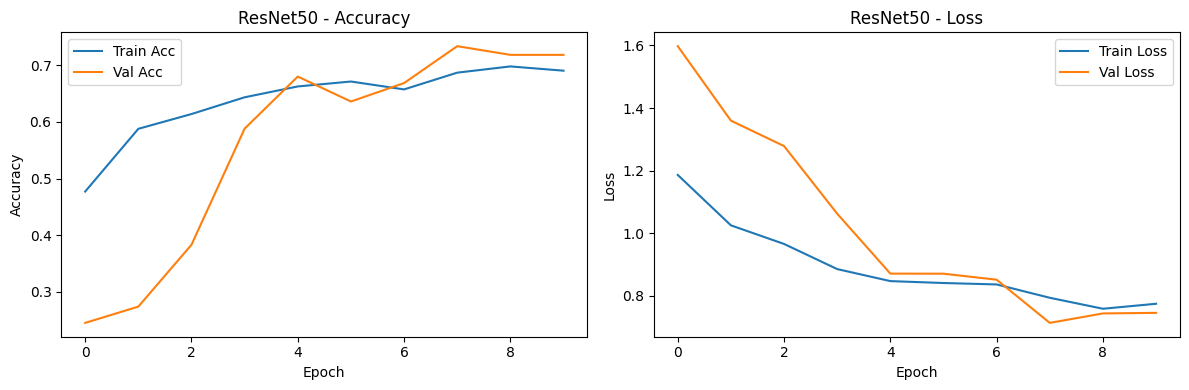

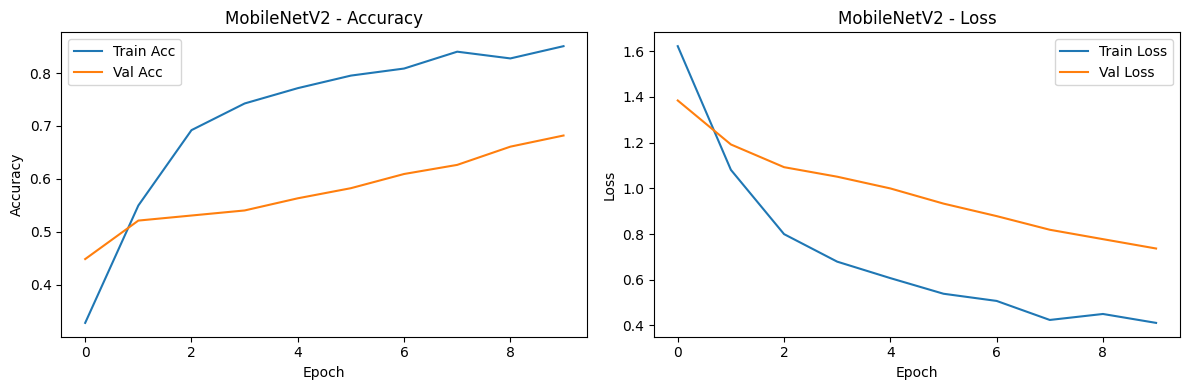

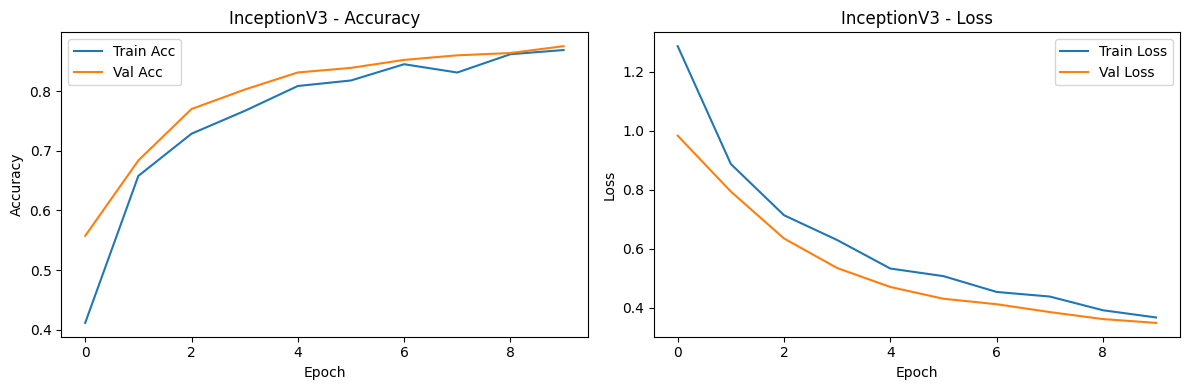

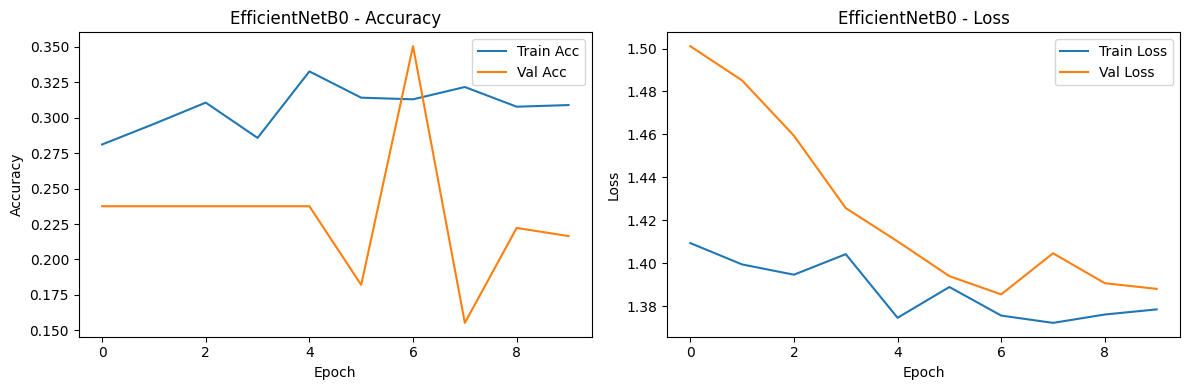

In [35]:
history_plot(cnn_history, title='Custom CNN')
history_plot(resnet_history, title='ResNet50')
history_plot(mobilenet_history, title='MobileNetV2')
history_plot(inception_history, title='InceptionV3')
history_plot(efficientnet_history, title='EfficientNetB0')

MODEL TRAINING-FINE TUNing

In [36]:
resnet_finetune_history=resnet_finetune_model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    callbacks=[early_stop,model_checkpoint],
    steps_per_epoch=len(train_generator),
    validation_steps=len(valid_generator)
)

Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - accuracy: 0.6766 - loss: 0.8024
Epoch 1: val_loss did not improve from 0.34891
54/54 ━━━━━━━━━━━━━━━━━━━━ 32s 593ms/step - accuracy: 0.6767 - loss: 0.8017 - val_accuracy: 0.7261 - val_loss: 0.7089
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 534ms/step - accuracy: 0.7284 - loss: 0.7288
Epoch 2: val_loss did not improve from 0.34891
54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 593ms/step - accuracy: 0.7280 - loss: 0.7294 - val_accuracy: 0.6513 - val_loss: 0.9036
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 537ms/step - accuracy: 0.6956 - loss: 0.7542
Epoch 3: val_loss did not improve from 0.34891
54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 598ms/step - accuracy: 0.6955 - loss: 0.7545 - val_accuracy: 0.7452 - val_loss: 0.6670
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 644ms/step - accuracy: 0.7215 - loss: 0.7101
Epoch 4: val_loss did not improve from 0.34891
54/54 ━━━━━━━━━━━━━━━━━━━━ 46s 697ms/step - accuracy: 0.7213 - loss: 0.7104 - val_accuracy: 0.7510 - val_loss: 0.6

In [37]:
mobilenet_finetune_history=mobilenet_finetune_model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    callbacks=[early_stop,model_checkpoint],
    steps_per_epoch=len(train_generator),
    validation_steps=len(valid_generator)
)

Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.8624 - loss: 0.3722
Epoch 1: val_loss did not improve from 0.34891
54/54 ━━━━━━━━━━━━━━━━━━━━ 30s 564ms/step - accuracy: 0.8622 - loss: 0.3727 - val_accuracy: 0.7126 - val_loss: 0.6805
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - accuracy: 0.8892 - loss: 0.3134
Epoch 2: val_loss did not improve from 0.34891
54/54 ━━━━━━━━━━━━━━━━━━━━ 30s 556ms/step - accuracy: 0.8889 - loss: 0.3141 - val_accuracy: 0.7375 - val_loss: 0.6371
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - accuracy: 0.8916 - loss: 0.3069
Epoch 3: val_loss did not improve from 0.34891
54/54 ━━━━━━━━━━━━━━━━━━━━ 30s 557ms/step - accuracy: 0.8916 - loss: 0.3071 - val_accuracy: 0.7510 - val_loss: 0.6040
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.8935 - loss: 0.3173
Epoch 4: val_loss did not improve from 0.34891
54/54 ━━━━━━━━━━━━━━━━━━━━ 40s 549ms/step - accuracy: 0.8934 - loss: 0.3175 - val_accuracy: 0.7759 - val_loss: 0.5

In [38]:
inception_finetune_history=inception_finetune_model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    callbacks=[early_stop,model_checkpoint],
    steps_per_epoch=len(train_generator),
    validation_steps=len(valid_generator)
)

Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - accuracy: 0.8857 - loss: 0.3416
Epoch 1: val_loss improved from 0.34891 to 0.33819, saving model to best_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 33s 599ms/step - accuracy: 0.8856 - loss: 0.3418 - val_accuracy: 0.8831 - val_loss: 0.3382
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - accuracy: 0.8811 - loss: 0.3458
Epoch 2: val_loss improved from 0.33819 to 0.32601, saving model to best_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 32s 591ms/step - accuracy: 0.8811 - loss: 0.3457 - val_accuracy: 0.8831 - val_loss: 0.3260
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 520ms/step - accuracy: 0.8897 - loss: 0.3249
Epoch 3: val_loss improved from 0.32601 to 0.32230, saving model to best_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 594ms/step - accuracy: 0.8897 - loss: 0.3246 - val_accuracy: 0.8812 - val_loss: 0.3223
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - accuracy: 0.9049 - loss: 0.3092
Epoch 4: val_loss improved from 0.32230 to 0.31451, saving model to best_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 599ms/step - accuracy: 0.9048 - loss: 0.3092 - val_accuracy: 0.8851 - val_loss: 0.3145
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 538ms/step - accuracy: 0.8886 - loss: 0.3179
Epoch 5: val_loss improved from 0.31451 to 0.30662, saving model to best_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 607ms/step - accuracy: 0.8887 - loss: 0.3177 - val_accuracy: 0.8908 - val_loss: 0.3066
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - accuracy: 0.9048 - loss: 0.2780
Epoch 6: val_loss improved from 0.30662 to 0.29365, saving model to best_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 32s 587ms/step - accuracy: 0.9047 - loss: 0.2781 - val_accuracy: 0.8908 - val_loss: 0.2937
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - accuracy: 0.8990 - loss: 0.2668
Epoch 7: val_loss improved from 0.29365 to 0.28577, saving model to best_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 33s 604ms/step - accuracy: 0.8992 - loss: 0.2667 - val_accuracy: 0.8889 - val_loss: 0.2858
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - accuracy: 0.9120 - loss: 0.2553
Epoch 8: val_loss improved from 0.28577 to 0.27918, saving model to best_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 602ms/step - accuracy: 0.9121 - loss: 0.2551 - val_accuracy: 0.8946 - val_loss: 0.2792
Epoch 9/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 513ms/step - accuracy: 0.9098 - loss: 0.2544
Epoch 9: val_loss did not improve from 0.27918
54/54 ━━━━━━━━━━━━━━━━━━━━ 30s 563ms/step - accuracy: 0.9100 - loss: 0.2542 - val_accuracy: 0.8927 - val_loss: 0.2823
Epoch 10/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - accuracy: 0.9289 - loss: 0.2186
Epoch 10: val_loss improved from 0.27918 to 0.27451, saving model to best_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 32s 590ms/step - accuracy: 0.9288 - loss: 0.2187 - val_accuracy: 0.8985 - val_loss: 0.2745


In [39]:
efficient_finetune_history=efficient_finetune_model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    callbacks=[early_stop,model_checkpoint],
    steps_per_epoch=len(train_generator),
    validation_steps=len(valid_generator)
)

Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.3133 - loss: 1.3838
Epoch 1: val_loss did not improve from 0.27451
54/54 ━━━━━━━━━━━━━━━━━━━━ 31s 563ms/step - accuracy: 0.3133 - loss: 1.3838 - val_accuracy: 0.1609 - val_loss: 1.3938
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.3382 - loss: 1.3679
Epoch 2: val_loss did not improve from 0.27451
54/54 ━━━━━━━━━━━━━━━━━━━━ 40s 554ms/step - accuracy: 0.3382 - loss: 1.3679 - val_accuracy: 0.2989 - val_loss: 1.3897
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - accuracy: 0.3388 - loss: 1.3622
Epoch 3: val_loss did not improve from 0.27451
54/54 ━━━━━━━━━━━━━━━━━━━━ 44s 610ms/step - accuracy: 0.3387 - loss: 1.3624 - val_accuracy: 0.1858 - val_loss: 1.3890
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - accuracy: 0.3193 - loss: 1.3685
Epoch 4: val_loss did not improve from 0.27451
54/54 ━━━━━━━━━━━━━━━━━━━━ 31s 566ms/step - accuracy: 0.3196 - loss: 1.3683 - val_accuracy: 0.4693 - val_loss: 1.3

**MODEL EVALUATION**

In [40]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score,precision_score,recall_score
import numpy as np
import seaborn as sns

**CUSTOM-CNN**

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 166ms/step

 Classification Report 

              precision    recall  f1-score   support

      glioma       0.70      0.98      0.82       171
  meningioma       0.13      0.03      0.05       124
    no_tumor       0.85      0.56      0.67        99
   pituitary       0.55      0.80      0.66       128

    accuracy                           0.63       522
   macro avg       0.56      0.59      0.55       522
weighted avg       0.56      0.63      0.57       522

Accuracy:0.6322
Precision:0.5562
F1_score:0.5681
Recall_score:0.6322


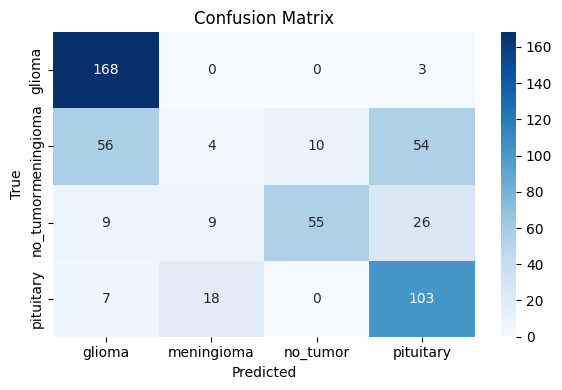

In [41]:
y_pred_probs=model.predict(valid_generator)
y_pred=np.argmax(y_pred_probs,axis=1)
y_true=valid_generator.classes

accuracy=accuracy_score(y_true,y_pred)
precision=precision_score(y_true,y_pred,average='weighted')
f1=f1_score(y_true,y_pred,average='weighted')
recall=recall_score(y_true,y_pred,average='weighted')

target_names=list(valid_generator.class_indices.keys())
print("\n Classification Report \n")
print(classification_report(y_true,y_pred,target_names=target_names))

print(f"Accuracy:{accuracy:.4f}")
print(f"Precision:{precision:.4f}")
print(f"F1_score:{f1:.4f}")
print(f"Recall_score:{recall:.4f}")

cm=confusion_matrix(y_true,y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',xticklabels=target_names,yticklabels=target_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


**ResNet50**

17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 431ms/step

 Classification Report 

              precision    recall  f1-score   support

      glioma       0.82      0.78      0.80       171
  meningioma       0.55      0.57      0.56       124
    no_tumor       0.82      0.80      0.81        99
   pituitary       0.77      0.81      0.79       128

    accuracy                           0.74       522
   macro avg       0.74      0.74      0.74       522
weighted avg       0.74      0.74      0.74       522

Accuracy:0.7414
Precision:0.7440
F1_score:0.7423
Recall_score:0.7414


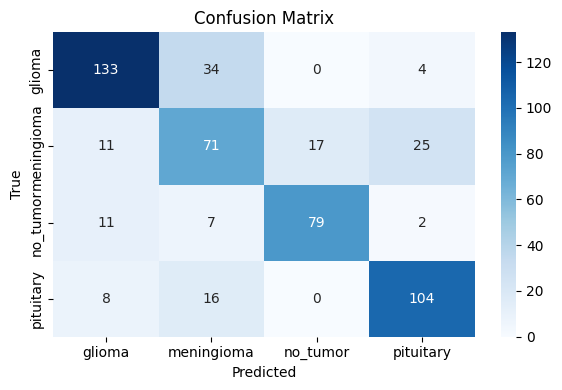

In [42]:
y_pred_probs=resnet_model.predict(valid_generator)
y_pred=np.argmax(y_pred_probs,axis=1)
y_true=valid_generator.classes

accuracy=accuracy_score(y_true,y_pred)
precision=precision_score(y_true,y_pred,average='weighted')
f1=f1_score(y_true,y_pred,average='weighted')
recall=recall_score(y_true,y_pred,average='weighted')

target_names=list(valid_generator.class_indices.keys())
print("\n Classification Report \n")
print(classification_report(y_true,y_pred,target_names=target_names))

print(f"Accuracy:{accuracy:.4f}")
print(f"Precision:{precision:.4f}")
print(f"F1_score:{f1:.4f}")
print(f"Recall_score:{recall:.4f}")

cm=confusion_matrix(y_true,y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',xticklabels=target_names,yticklabels=target_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


**MobileNetV2**

17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 316ms/step

 Classification Report 

              precision    recall  f1-score   support

      glioma       0.81      0.99      0.89       171
  meningioma       0.92      0.52      0.67       124
    no_tumor       0.89      0.88      0.88        99
   pituitary       0.86      0.96      0.91       128

    accuracy                           0.85       522
   macro avg       0.87      0.84      0.84       522
weighted avg       0.86      0.85      0.84       522

Accuracy:0.8525
Precision:0.8619
F1_score:0.8408
Recall_score:0.8525


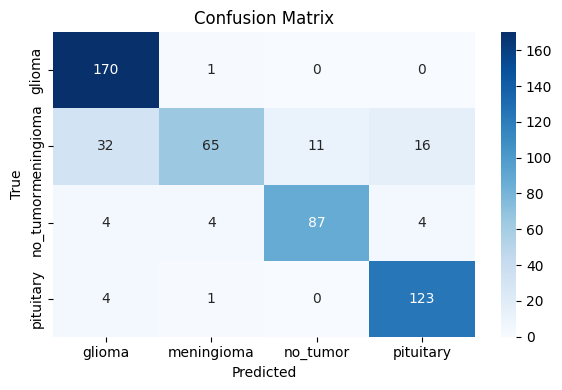

In [43]:
y_pred_probs=mobilenet_model.predict(valid_generator)
y_pred=np.argmax(y_pred_probs,axis=1)
y_true=valid_generator.classes

accuracy=accuracy_score(y_true,y_pred)
precision=precision_score(y_true,y_pred,average='weighted')
f1=f1_score(y_true,y_pred,average='weighted')
recall=recall_score(y_true,y_pred,average='weighted')

target_names=list(valid_generator.class_indices.keys())
print("\n Classification Report \n")
print(classification_report(y_true,y_pred,target_names=target_names))

print(f"Accuracy:{accuracy:.4f}")
print(f"Precision:{precision:.4f}")
print(f"F1_score:{f1:.4f}")
print(f"Recall_score:{recall:.4f}")

cm=confusion_matrix(y_true,y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',xticklabels=target_names,yticklabels=target_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


**InceptionV3**

17/17 ━━━━━━━━━━━━━━━━━━━━ 15s 532ms/step

 Classification Report 

              precision    recall  f1-score   support

      glioma       0.95      0.99      0.97       171
  meningioma       0.88      0.72      0.79       124
    no_tumor       0.91      0.91      0.91        99
   pituitary       0.83      0.95      0.89       128

    accuracy                           0.90       522
   macro avg       0.89      0.89      0.89       522
weighted avg       0.90      0.90      0.90       522

Accuracy:0.8985
Precision:0.8991
F1_score:0.8959
Recall_score:0.8985


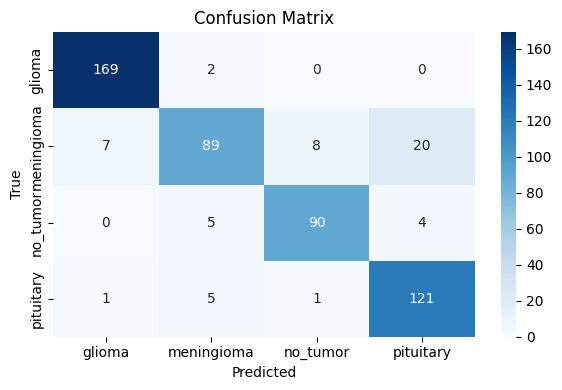

In [44]:
y_pred_probs=inception_model.predict(valid_generator)
y_pred=np.argmax(y_pred_probs,axis=1)
y_true=valid_generator.classes

accuracy=accuracy_score(y_true,y_pred)
precision=precision_score(y_true,y_pred,average='weighted')
f1=f1_score(y_true,y_pred,average='weighted')
recall=recall_score(y_true,y_pred,average='weighted')

target_names=list(valid_generator.class_indices.keys())
print("\n Classification Report \n")
print(classification_report(y_true,y_pred,target_names=target_names))

print(f"Accuracy:{accuracy:.4f}")
print(f"Precision:{precision:.4f}")
print(f"F1_score:{f1:.4f}")
print(f"Recall_score:{recall:.4f}")

cm=confusion_matrix(y_true,y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',xticklabels=target_names,yticklabels=target_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


**EfficientNetB0**

17/17 ━━━━━━━━━━━━━━━━━━━━ 15s 582ms/step

 Classification Report 

              precision    recall  f1-score   support

      glioma       0.46      0.97      0.63       171
  meningioma       0.00      0.00      0.00       124
    no_tumor       0.48      0.80      0.60        99
   pituitary       0.00      0.00      0.00       128

    accuracy                           0.47       522
   macro avg       0.24      0.44      0.31       522
weighted avg       0.24      0.47      0.32       522

Accuracy:0.4693
Precision:0.2434
F1_score:0.3196
Recall_score:0.4693


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

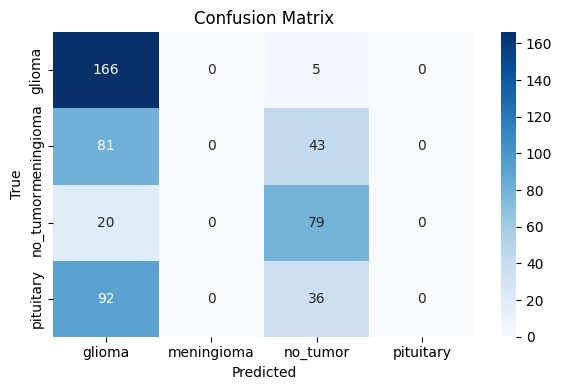

In [45]:
y_pred_probs=efficientnet_model.predict(valid_generator)
y_pred=np.argmax(y_pred_probs,axis=1)
y_true=valid_generator.classes

accuracy=accuracy_score(y_true,y_pred)
precision=precision_score(y_true,y_pred,average='weighted')
f1=f1_score(y_true,y_pred,average='weighted')
recall=recall_score(y_true,y_pred,average='weighted')

target_names=list(valid_generator.class_indices.keys())
print("\n Classification Report \n")
print(classification_report(y_true,y_pred,target_names=target_names))

print(f"Accuracy:{accuracy:.4f}")
print(f"Precision:{precision:.4f}")
print(f"F1_score:{f1:.4f}")
print(f"Recall_score:{recall:.4f}")

cm=confusion_matrix(y_true,y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',xticklabels=target_names,yticklabels=target_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


**MODEL EVALUATION-FINE TUNING**

**ResNet50-FINE TUNING**

17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step

 Classification Report 

              precision    recall  f1-score   support

      glioma       0.82      0.78      0.80       171
  meningioma       0.55      0.57      0.56       124
    no_tumor       0.82      0.80      0.81        99
   pituitary       0.77      0.81      0.79       128

    accuracy                           0.74       522
   macro avg       0.74      0.74      0.74       522
weighted avg       0.74      0.74      0.74       522

Accuracy:0.7414
Precision:0.7440
F1_score:0.7423
Recall_score:0.7414


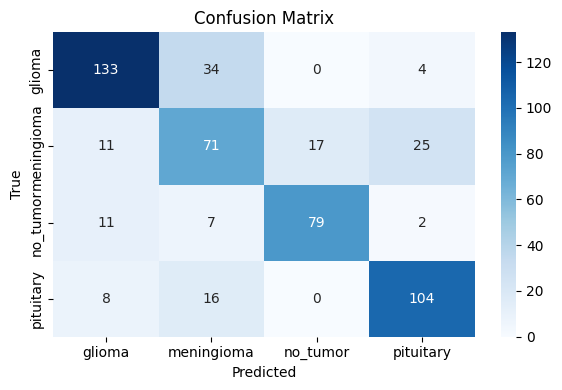

In [46]:
y_pred_probs=resnet_finetune_model.predict(valid_generator)
y_pred=np.argmax(y_pred_probs,axis=1)
y_true=valid_generator.classes

accuracy=accuracy_score(y_true,y_pred)
precision=precision_score(y_true,y_pred,average='weighted')
f1=f1_score(y_true,y_pred,average='weighted')
recall=recall_score(y_true,y_pred,average='weighted')

target_names=list(valid_generator.class_indices.keys())
print("\n Classification Report \n")
print(classification_report(y_true,y_pred,target_names=target_names))

print(f"Accuracy:{accuracy:.4f}")
print(f"Precision:{precision:.4f}")
print(f"F1_score:{f1:.4f}")
print(f"Recall_score:{recall:.4f}")

cm=confusion_matrix(y_true,y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',xticklabels=target_names,yticklabels=target_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

**MobileNetV2-FINE TUNING**

17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step

 Classification Report 

              precision    recall  f1-score   support

      glioma       0.81      0.99      0.89       171
  meningioma       0.92      0.52      0.67       124
    no_tumor       0.89      0.88      0.88        99
   pituitary       0.86      0.96      0.91       128

    accuracy                           0.85       522
   macro avg       0.87      0.84      0.84       522
weighted avg       0.86      0.85      0.84       522

Accuracy:0.8525
Precision:0.8619
F1_score:0.8408
Recall_score:0.8525


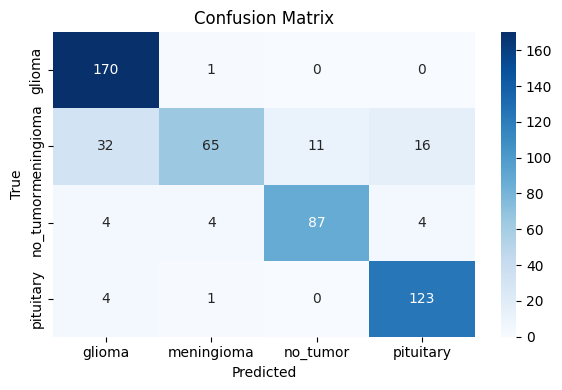

In [47]:
y_pred_probs=mobilenet_finetune_model.predict(valid_generator)
y_pred=np.argmax(y_pred_probs,axis=1)
y_true=valid_generator.classes

accuracy=accuracy_score(y_true,y_pred)
precision=precision_score(y_true,y_pred,average='weighted')
f1=f1_score(y_true,y_pred,average='weighted')
recall=recall_score(y_true,y_pred,average='weighted')

target_names=list(valid_generator.class_indices.keys())
print("\n Classification Report \n")
print(classification_report(y_true,y_pred,target_names=target_names))

print(f"Accuracy:{accuracy:.4f}")
print(f"Precision:{precision:.4f}")
print(f"F1_score:{f1:.4f}")
print(f"Recall_score:{recall:.4f}")

cm=confusion_matrix(y_true,y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',xticklabels=target_names,yticklabels=target_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

**InceptionV3-FINE TUNING**

17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step

 Classification Report 

              precision    recall  f1-score   support

      glioma       0.95      0.99      0.97       171
  meningioma       0.88      0.72      0.79       124
    no_tumor       0.91      0.91      0.91        99
   pituitary       0.83      0.95      0.89       128

    accuracy                           0.90       522
   macro avg       0.89      0.89      0.89       522
weighted avg       0.90      0.90      0.90       522

Accuracy:0.8985
Precision:0.8991
F1_score:0.8959
Recall_score:0.8985


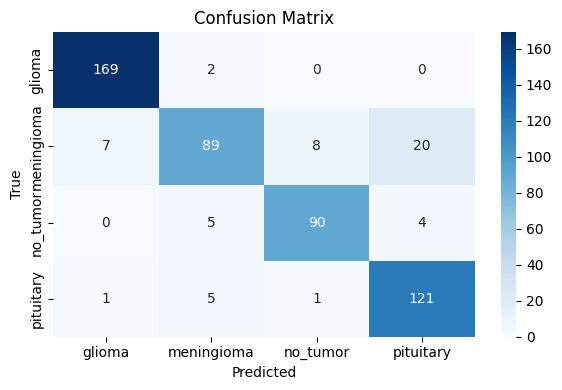

In [48]:
y_pred_probs=inception_finetune_model.predict(valid_generator)
y_pred=np.argmax(y_pred_probs,axis=1)
y_true=valid_generator.classes

accuracy=accuracy_score(y_true,y_pred)
precision=precision_score(y_true,y_pred,average='weighted')
f1=f1_score(y_true,y_pred,average='weighted')
recall=recall_score(y_true,y_pred,average='weighted')

target_names=list(valid_generator.class_indices.keys())
print("\n Classification Report \n")
print(classification_report(y_true,y_pred,target_names=target_names))

print(f"Accuracy:{accuracy:.4f}")
print(f"Precision:{precision:.4f}")
print(f"F1_score:{f1:.4f}")
print(f"Recall_score:{recall:.4f}")

cm=confusion_matrix(y_true,y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',xticklabels=target_names,yticklabels=target_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

**EfficientNetB0-FINE TUNING**

17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step

 Classification Report 

              precision    recall  f1-score   support

      glioma       0.46      0.97      0.63       171
  meningioma       0.00      0.00      0.00       124
    no_tumor       0.48      0.80      0.60        99
   pituitary       0.00      0.00      0.00       128

    accuracy                           0.47       522
   macro avg       0.24      0.44      0.31       522
weighted avg       0.24      0.47      0.32       522

Accuracy:0.4693
Precision:0.2434
F1_score:0.3196
Recall_score:0.4693


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

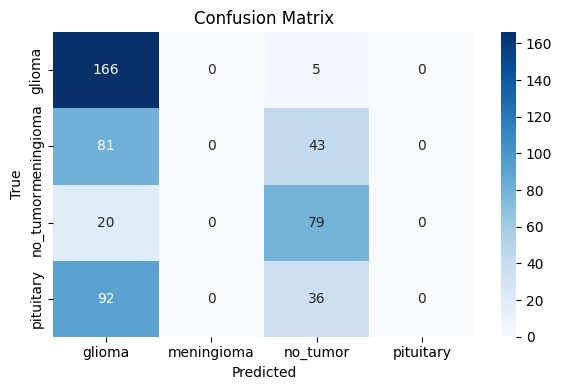

In [49]:
y_pred_probs=efficient_finetune_model.predict(valid_generator)
y_pred=np.argmax(y_pred_probs,axis=1)
y_true=valid_generator.classes

accuracy=accuracy_score(y_true,y_pred)
precision=precision_score(y_true,y_pred,average='weighted')
f1=f1_score(y_true,y_pred,average='weighted')
recall=recall_score(y_true,y_pred,average='weighted')

target_names=list(valid_generator.class_indices.keys())
print("\n Classification Report \n")
print(classification_report(y_true,y_pred,target_names=target_names))

print(f"Accuracy:{accuracy:.4f}")
print(f"Precision:{precision:.4f}")
print(f"F1_score:{f1:.4f}")
print(f"Recall_score:{recall:.4f}")

cm=confusion_matrix(y_true,y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',xticklabels=target_names,yticklabels=target_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

**MODEL COMPARSION**

/tmp/ipython-input-2-142138210.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models,y=values,palette='viridis')
/tmp/ipython-input-2-142138210.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models,y=values,palette='viridis')
/tmp/ipython-input-2-142138210.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models,y=values,palette='viridis')
/tmp/ipython-input-2-142138210.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set 

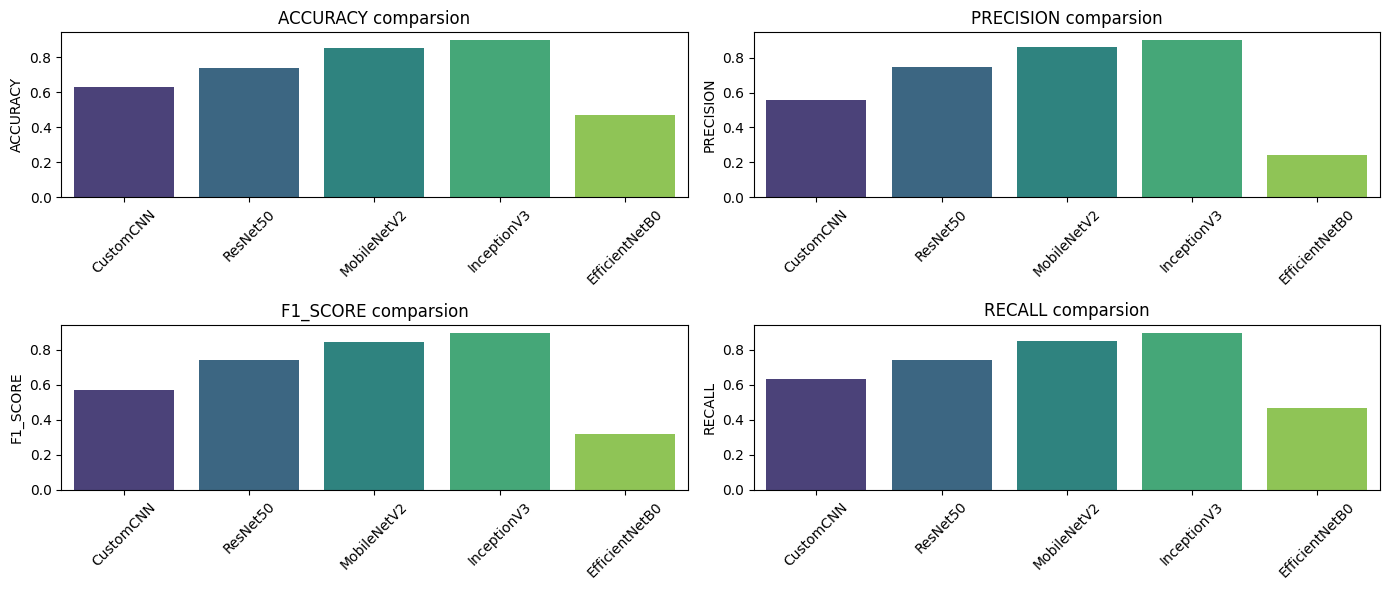

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

models = ['CustomCNN', 'ResNet50', 'MobileNetV2', 'InceptionV3', 'EfficientNetB0']
accuracy = [0.6322, 0.7414, 0.8525, 0.8985, 0.4693]
precision = [0.5562, 0.7440, 0.8619, 0.8991, 0.2434]
f1_score = [0.5681, 0.7423, 0.8408, 0.8959, 0.3196]
recall = [0.6322, 0.7414, 0.8525, 0.8985, 0.4693]

metrics_dict={'ACCURACY':accuracy,'PRECISION':precision,'F1_SCORE':f1_score,'RECALL':recall}

plt.figure(figsize=(14,6))
for i,(metrics_name,values) in enumerate(metrics_dict.items()):
  plt.subplot(2,2,i+1)
  sns.barplot(x=models,y=values,palette='viridis')
  plt.title(f'{metrics_name} comparsion')
  plt.ylabel(metrics_name)
  plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
y_pred_probs=inception_finetune_model.predict(test_generator)
y_pred=np.argmax(y_pred_probs,axis=1)
y_true=test_generator.classes

accuracy=accuracy_score(y_true,y_pred)
precision=precision_score(y_true,y_pred,average='weighted')
f1=f1_score(y_true,y_pred,average='weighted')
recall=recall_score(y_true,y_pred,average='weighted')

target_names=list(test_generator.class_indices.keys())
print("\n Classification Report \n")
print(classification_report(y_true,y_pred,target_names=target_names))

print(f"Accuracy:{accuracy:.4f}")
print(f"Precision:{precision:.4f}")
print(f"F1_score:{f1:.4f}")
print(f"Recall_score:{recall:.4f}")

cm=confusion_matrix(y_true,y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',xticklabels=target_names,yticklabels=target_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

INCEPTIONV3 MODEL PERFORMING WELL

In [ ]:
inception_finetune_model.save("inception_finetune_model.h5")

**STREAMLIT**

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!pip install streamlit streamlit-option-menu -q
!npm install -g localtunnel

In [ ]:
%%writefile app.py

import streamlit as st
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array

@st.cache_resource
def load_brain_tumor_model():
    model = load_model("inception_finetune_model.h5")
    return model

model = load_brain_tumor_model()

class_names = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']

st.set_page_config(page_title="Brain Tumor Detection", layout="wide")
st.title("Brain Tumor MRI Classifier")

uploaded_file = st.file_uploader("Upload a Brain MRI Image", type=["jpg", "jpeg", "png"])

if uploaded_file:
    image = Image.open(uploaded_file).convert('RGB')
    st.image(image, caption='Uploaded MRI Image', use_column_width=True)

    image = image.resize((224, 224))
    image_array = img_to_array(image)
    image_array = np.expand_dims(image_array, axis=0)
    image_array = image_array / 255.0

    predictions = model.predict(image_array)[0]
    predicted_idx = np.argmax(predictions)
    confidence = predictions[predicted_idx]

    st.subheader("Prediction")
    st.markdown(f"**Tumor Type:** `{class_names[predicted_idx]}`")
    st.markdown(f"**Confidence Score:** `{confidence * 100:.2f}%`")

    st.subheader("Class-wise Confidence Scores")
    for i, prob in enumerate(predictions):
        st.write(f"{class_names[i]}: {prob * 100:.2f}%")



In [ ]:
!streamlit run app.py & npx localtunnel --port 8501